**Step 1: Read and Organize Data**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

#Read data from Google Sheet: experimentos.analitica.datos - EncuestaCineColombiano_Respuestas
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQC3CXrmRk6mpK9-DrpO--faGVT_KsR8rj-AToUfFlsbKNnUB2wVslmNYiFT1pv80Z5gp76tgSqp1aN/pub?gid=1802142849&single=true&output=tsv", sep="\t")

df.columns = ['A','B','C','D','E']

#Transform dataset: Opinion-Type
good_df = df[['C']]
good_df['Opinion'] = "POSITIVE" 

bad_df = df[['D']]
bad_df.columns = ['C']
bad_df['Opinion'] = "NEGATIVE" 

df_op = pd.concat([good_df,bad_df])
df_op.columns = ['Opinion','Type']

print(df_op.head())

df_op.groupby(['Type']).count()

                                             Opinion      Type
0  Son películas divertidas, que resaltan los val...  POSITIVE
1                                          la comida  POSITIVE
2                                Diversidad cultural  POSITIVE
3  Es barato, en la actualidad han mejorado el se...  POSITIVE
4           Humor, Cultura, Mujeres, puerta al mundo  POSITIVE


,Opinion
Type,
NEGATIVE,362
POSITIVE,361


**Step 2: Define a text preprocessing function**

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish')) 
stop_words = stop_words.union(set(['me', 'le', 'da', 'mi', 'su', 'ha', 'he', 'ya', 'un', 'una', 'es','del', 'las', 'los', 'en', 'que', 'y', 'la','de']))

def fast_preproc(text):
  words = word_tokenize(text.lower())
  words = [word for word in words if not word in stop_words] 
  words = [stemmer.stem(word) for word in words]  
  try:
    text = " ".join(str(word) for word in words)
  except Exception as e:
    print(e)
    pass
  return text

print(fast_preproc("La que me gusta"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
gust


**Step 3: Text preprocessing**

In [3]:
df_op['Opinion'] = df_op['Opinion'].astype(str)

df_op = df_op.assign(
    TextPreproc=lambda df: df_op.Opinion.apply(fast_preproc)
)

df_op.head()

,Opinion,Type,TextPreproc
0,"Son películas divertidas, que resaltan los val...",POSITIVE,"pelicul divert , resalt valor comport tipic co..."
1,la comida,POSITIVE,com
2,Diversidad cultural,POSITIVE,divers cultural
3,"Es barato, en la actualidad han mejorado el se...",POSITIVE,"barat , actual mejor servici personaliz sill c..."
4,"Humor, Cultura, Mujeres, puerta al mundo",POSITIVE,"humor , cultur , mujer , puert mund"


**Step 4: Split dataset**

In [4]:
#Split dataset
X = df_op['TextPreproc']
Y = df_op['Type']

**Step 5: Data transformation with TF_IDF**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

#Tokenize and build vocabulary
vec.fit(X)
print("\nVocabulary:\n")
print(vec.vocabulary_)

#Encode documents
trans_text_train = vec.transform(X)

#Print Document-Term Matrix
df = pd.DataFrame(trans_text_train.toarray(), columns=vec.get_feature_names())
df.head()


Vocabulary:

{'pelicul': 703, 'divert': 306, 'resalt': 835, 'valor': 974, 'comport': 203, 'tipic': 935, 'colombian': 185, 'com': 188, 'divers': 304, 'cultural': 259, 'barat': 111, 'actual': 23, 'mejor': 594, 'servici': 870, 'personaliz': 716, 'sill': 877, 'cin': 170, 'humor': 488, 'cultur': 258, 'mujer': 625, 'puert': 784, 'mund': 627, 'colombi': 184, 'consolid': 219, 'industri': 520, 'cien': 167, 'años': 109, 'obtuv': 659, 'calid': 132, 'tecnic': 921, 'varied': 977, 'temat': 925, 'necesari': 643, 'proyect': 778, 'acerv': 13, 'alto': 48, 'nivel': 647, 'pas': 696, 'exigent': 392, 'espect': 368, 'internacional': 536, 'pus': 789, 'aqu': 69, 'mir': 607, 'realiz': 806, 'pud': 781, 'viv': 999, 'ello': 326, 'hac': 475, 'parec': 690, 'sueñ': 902, 'impos': 506, 'comic': 195, 'muestr': 622, 'realid': 802, 'pais': 679, 'obtien': 658, 'dividend': 307, 'conoc': 215, 'poc': 729, 'recurs': 817, 'deb': 266, 'uso': 969, 'creativ': 246, 'imagin': 501, 'aspect': 86, 'comedi': 190, 'fantas': 415, 'capac'

,30,abarc,abord,abraz,absurd,aburr,aburridor,accequ,acces,accesibil,accion,acerc,acert,acerv,aclam,acord,acostumbr,acpect,actor,actoral,actric,actu,actuacion,actual,acud,adecu,adem,ademas,adicional,administr,adult,afin,agent,aglomer,agrad,agres,agud,ahi,ahor,air,...,usar,uso,usual,utiliz,va,valios,valor,van,vari,varied,ve,vec,ven,vend,vent,veo,ver,veran,verd,verl,vez,vici,vid,vide,viej,violeci,violenci,violent,visit,vist,visual,viv,vivenci,vocabulari,volet,vulg,vulgar,vulner,zon,ñer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.432284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Step 6: Split Test-Train Datasets**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.15)
print("Train and test shapes:\n")
print("Train. X: " + str(X_train.shape) + " - Y:" + str(Y_train.shape))
print("Test. X: " + str(X_test.shape) + " - Y:" + str(Y_test.shape))

Train and test shapes:

Train. X: (615, 1008) - Y:(615,)
Test. X: (109, 1008) - Y:(109,)


**Step 7. Build a Classifier**

In [7]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X_train, Y_train)

from sklearn.metrics import classification_report,confusion_matrix

#Predice para el conjunto de testeo.
y_pred = classifier.predict(X_test)

print("\nMatriz de confusión:\n")
print(confusion_matrix(Y_test,y_pred))

print("\nEstadisticas del clasificador:\n")
print(classification_report(Y_test,y_pred))


Matriz de confusión:

[[44  6]
 [ 9 50]]

Estadisticas del clasificador:

              precision    recall  f1-score   support

    NEGATIVE       0.83      0.88      0.85        50
    POSITIVE       0.89      0.85      0.87        59

    accuracy                           0.86       109
   macro avg       0.86      0.86      0.86       109
weighted avg       0.86      0.86      0.86       109



**Step 8. Predict New Instance**

In [8]:
new_opinion = ["Me parecen malas por la razon de que no llevan un hilo conductor claro"]
#new_opinion = ["Me gustan porque son chistosas"]

Xt_new = [fast_preproc(str(new_opinion))]

trans_new_doc = vec.transform(Xt_new) #Use same TfIdfVectorizer

print("\nPredicted result: " + str(classifier.predict(trans_new_doc)))



Predicted result: ['NEGATIVE']


**Step 8. Clustering Text**

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 

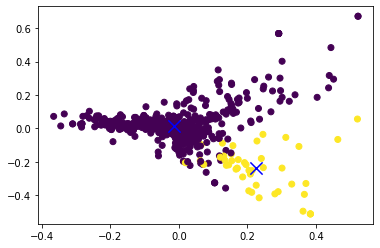

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

X = df_op['TextPreproc']

vec = TfidfVectorizer()
vec.fit(X)
trans_text_train = vec.transform(X)

cls = KMeans(n_clusters=2, random_state=0)
cls.fit(trans_text_train)

# Asign cluster for each sample
cls.predict(trans_text_train)

print(cls.labels_) #0: First cluster, 1: Second cluster, 2: Third cluster...
print(cls.labels_.shape)
print(sum(cls.labels_[0:246]))
print(sum(cls.labels_[247:494]))

# Use PCA in order to reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(trans_text_train.toarray())

# Reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(trans_text_train))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')